**Load the Emotion-Labeled Dataset**

In [8]:
import os
import librosa
import numpy as np

# Path to dataset
DATA_PATH = "ravdess_data/"

# Load an example file
file_path = os.path.join(DATA_PATH, "03-01-01-01-01-01-01.wav")  # Update with actual file
signal, sr = librosa.load(file_path, sr=22050)  # 22.05 kHz is standard for speech
print(f"Audio duration: {librosa.get_duration(y=signal, sr=sr)} seconds")

Audio duration: 3.3033106575963718 seconds


**Visualize Raw Waveform**

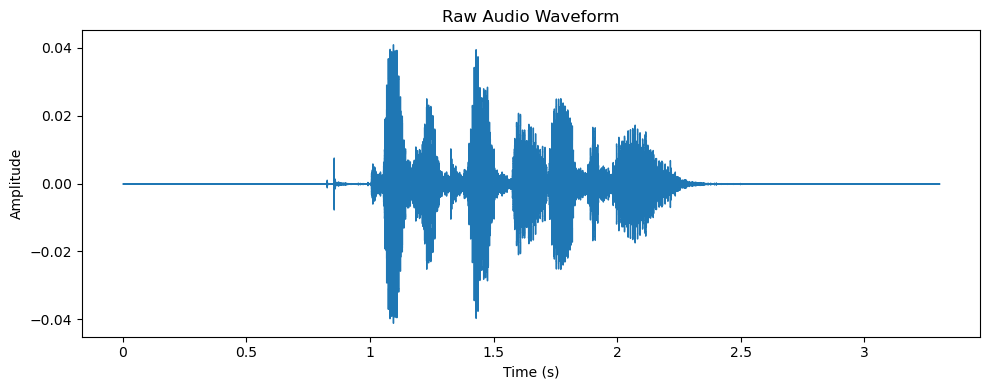

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Raw Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

**Compute MFCCs from Audio**

In [10]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

# Print shape: (13 coefficients × time frames)
print("MFCCs shape:", mfccs.shape)

MFCCs shape: (13, 143)


**Visualize MFCCs**

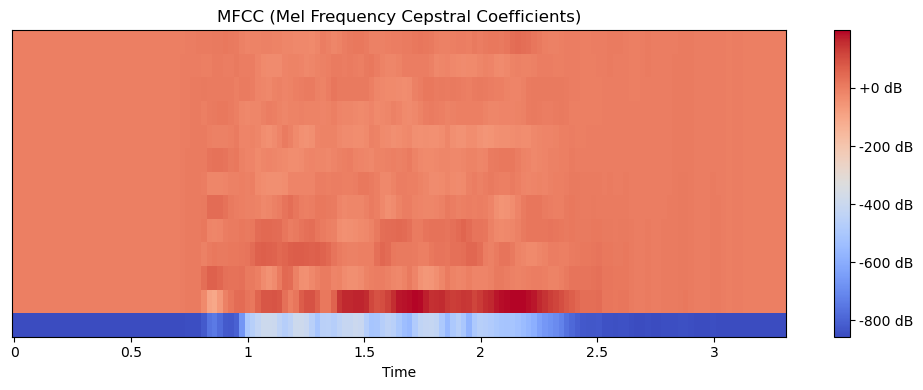

In [11]:
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title("MFCC (Mel Frequency Cepstral Coefficients)")
plt.tight_layout()
plt.show()

**End-to-End Function for Preprocessing**

In [12]:
def extract_features(file_path, n_mfcc=13):
    signal, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)  # Mean pooling
    return mfccs_processed

**Batch Processing for Dataset Preparation**

In [13]:
features = []
labels = []

for file_name in os.listdir(DATA_PATH):
    if file_name.endswith(".wav"):
        emotion_label = file_name.split("-")[2]  # Example: extract from file naming convention
        file_path = os.path.join(DATA_PATH, file_name)
        mfcc = extract_features(file_path)
        features.append(mfcc)
        labels.append(emotion_label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

**Building the Emotion Classifier**

*Step 1: Split the Data*

In [14]:
from sklearn.model_selection import train_test_split

# X = list of MFCC feature arrays
# y = corresponding emotion labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

*Step 2: Choose the Right Models*

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

*Step 3: Tune and Validate with Cross-Validation*

In [16]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define hyperparameter grids
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

svm_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1]
}

# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10)

# Grid Search
rf_grid = GridSearchCV(rf_model, rf_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid = GridSearchCV(svm_model, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit models
rf_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': ['scale', 0.01, 0.1]},
             scoring='accuracy')

*Step 4: Evaluate the Model*

Random Forest Accuracy: 0.5579710144927537
SVM Accuracy: 0.4782608695652174


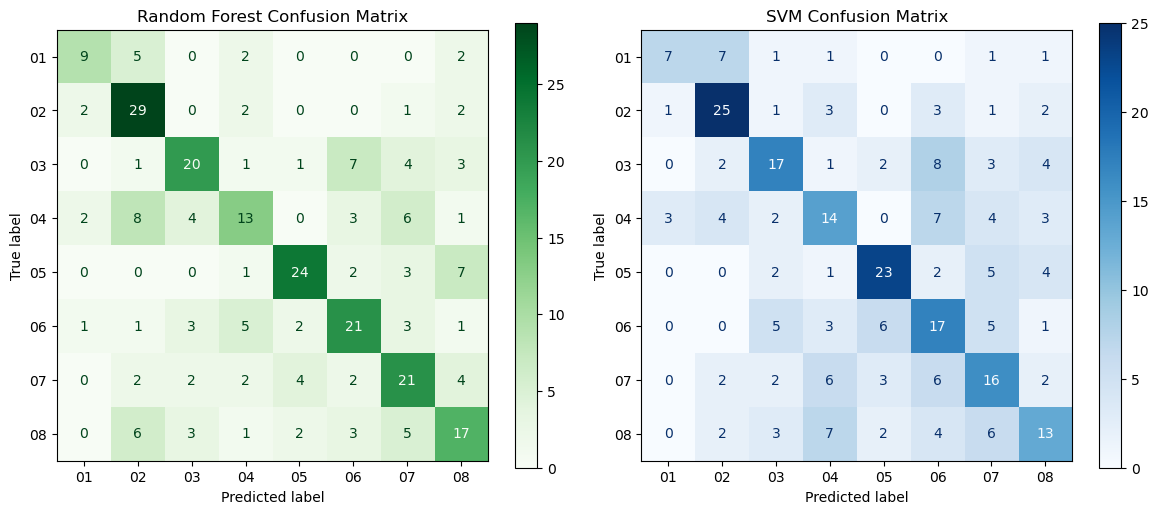

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Best estimators from grid search
best_rf = rf_grid.best_estimator_
best_svm = svm_grid.best_estimator_

# Predictions
rf_preds = best_rf.predict(X_test)
svm_preds = best_svm.predict(X_test)

# Accuracy scores
rf_acc = accuracy_score(y_test, rf_preds)
svm_acc = accuracy_score(y_test, svm_preds)

print("Random Forest Accuracy:", rf_acc)
print("SVM Accuracy:", svm_acc)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds), display_labels=best_rf.classes_).plot(ax=axes[0], cmap="Greens")
axes[0].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, svm_preds), display_labels=best_svm.classes_).plot(ax=axes[1], cmap="Blues")
axes[1].set_title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [18]:
import joblib

# After grid search and fitting:
joblib.dump(rf_grid.best_estimator_, "model.pkl")

['model.pkl']

**Confusion Matrix & Classification Report**

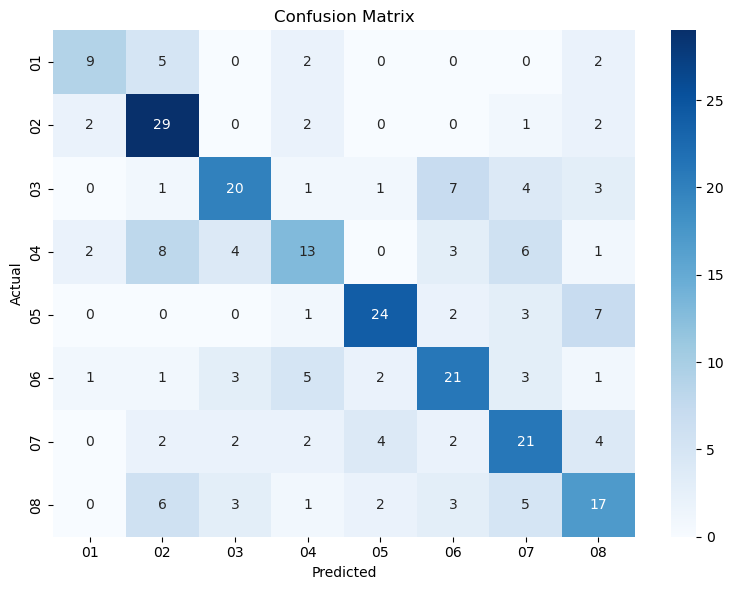

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

model = joblib.load("model.pkl")

#y_true: true labels
y_pred = model.predict(X_test)

def plot_confusion_matrix(y_true, y_pred, labels):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Example usage:
labels = ['angry', 'calm', 'happy', 'sad']
plot_confusion_matrix(y_test, y_pred, labels=labels)

**Per-Class Accuracy Bar Chart**

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\fu

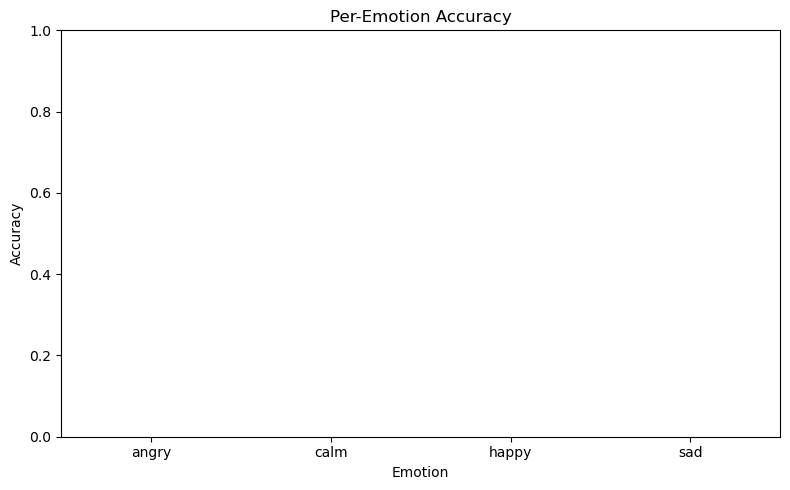

In [29]:
import pandas as pd

def plot_per_class_accuracy(y_true, y_pred, labels):
    from sklearn.metrics import accuracy_score
    accuracies = {}
    for label in labels:
        indices = [i for i, y in enumerate(y_true) if y == label]
        sub_y_true = [y_true[i] for i in indices]
        sub_y_pred = [y_pred[i] for i in indices]
        accuracies[label] = accuracy_score(sub_y_true, sub_y_pred)

    # Convert to DataFrame
    df = pd.DataFrame(list(accuracies.items()), columns=['Emotion', 'Accuracy'])

    # Plot
    df.plot(kind='bar', x='Emotion', y='Accuracy', legend=False, color='skyblue', figsize=(8, 5))
    plt.ylim(0, 1)
    plt.title('Per-Emotion Accuracy')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_per_class_accuracy(y_test, y_pred, labels)

**Hyperparameter Tuning: Random Forest**

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.5543603455368162


**Hyperparameter Tuning: SVM with RBF Kernel**

In [31]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best SVM Parameters:", grid.best_params_)
print("Best SVM Score:", grid.best_score_)

Best SVM Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM Score: 0.48917317976141506


**Deep Learning Alternative: CNN for Audio Spectrogram**

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage:
input_shape = (128, 128, 1)  # e.g., Mel spectrogram dimensions
num_classes = 4  # angry, calm, happy, sad
model = build_cnn_model(input_shape, num_classes)
model.summary()

C:\Users\Dumbs\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,260 (28.20 MB)

 Trainable params: 7,392,260 (28.20 MB)

 Non-trainable params: 0 (0.00 B)